In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import pyemu

## Monte Carlo with Freyberg Model

Adapted from the examples provided with `pyemu`


## Using `pyemu`

In [2]:
import freyberg_setup
freyberg_setup.setup_pest_pp()



['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_monte_carlo/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1

In [3]:
os.getcwd()

'/Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_monte_carlo'

In [4]:
pst_file = freyberg_setup.PST_NAME_PP
working_dir = freyberg_setup.WORKING_DIR_PP
pst = pyemu.Pst(os.path.join(working_dir,pst_file))

In [5]:
mc = pyemu.MonteCarlo(pst=pst,verbose=False)

## Drawing from the prior
Each ``MonteCarlo`` instance has a ``parensemble`` attribute which itself is an instance of ``Ensemble`` class, which is derived from ``pandas.DataFrame``.  What all that means is that the parameter ensembles behave just like ```DataFrame```s

### ```draw```
The ``draw`` method is the main entry point into getting realizations. It accepts several optional arguments.  Without any args, it makes a single draw from the prior, which uses a $\boldsymbol{\mu}$ (mean) vector of the parameter values listed in the pest control file:


In [6]:
mc.draw()
print(mc.parensemble.shape)

(1, 58)


``draw`` also accepts a ``num_reals`` argument to specify the number of draws to make:

In [7]:
mc.draw(num_reals=200)
print(mc.parensemble.shape)
print(mc.parensemble.mean().head())

(200, 58)
parnme
rch_0     1.021305
rch_1     1.000754
hk00      9.667552
hk01     10.769402
hk02      8.155498
dtype: float64


## plotting

Since ```ParameterEnsemble``` is dervied from ```pandas.DataFrame```, it has all the cool methods and attributes we all love.  Let's compare the results of drawing from a uniform vs a gaussian distribution.  This may take some time.

In [8]:
mc.parensemble.columns

Index(['rch_0', 'rch_1', 'hk00', 'hk01', 'hk02', 'hk03', 'hk04', 'hk05',
       'hk06', 'hk07', 'hk08', 'hk09', 'hk10', 'hk11', 'hk12', 'hk13', 'hk14',
       'hk15', 'hk16', 'hk17', 'hk18', 'hk19', 'hk20', 'hk21', 'hk22', 'hk23',
       'hk24', 'hk25', 'hk26', 'hk27', 'hk28', 'hk29', 'hk30', 'hk31', 'hk32',
       'hk33', 'hk34', 'hk35', 'hk36', 'hk37', 'hk38', 'hk39', 'hk40', 'hk41',
       'hk42', 'hk43', 'w0_r09_c16', 'w0_r11_c13', 'w0_r20_c14', 'w0_r26_c10',
       'w0_r29_c06', 'w0_r34_c12', 'w1_r09_c16', 'w1_r11_c13', 'w1_r20_c14',
       'w1_r26_c10', 'w1_r29_c06', 'w1_r34_c12'],
      dtype='object', name='parnme')

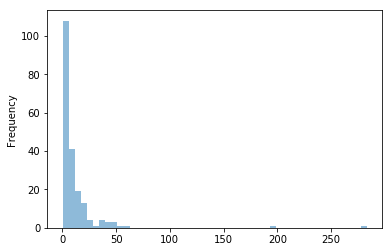

In [9]:
ax = plt.subplot(111)
partoplot = 'hk10'
mc.parensemble.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5)

In [10]:
def plot_first_10_reals(paren):
    arrs = []
    pp_df = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
    pp_df.loc[:,"iidx"] = pp_df.index
    for real in paren.index.values[:10]:
        pp_df.index = pp_df.parnme
        pp_df.loc[:,"parval1"] = paren.loc[real,pp_df.parnme].T
        pp_df.index = pp_df.iidx
        arr = pyemu.utils.gw_utils.fac2real(pp_df,os.path.join(working_dir,"hkpp.dat.fac"))
        arrs.append(np.log10(np.loadtxt(arr)))
    mx,mn = -1.0E+10,1.0e+10
    for arr in arrs:
        mx = max(mx,arr.max())
        mn = min(mn,arr.min())
    fig = plt.figure(figsize=(10,10))
    for i,arr in enumerate(arrs):
        ax = plt.subplot(2,5,i+1)
        ax.imshow(arr)#,vmax=mx,vmin=mn,interpolation="nearest")
    plt.show()
    
    

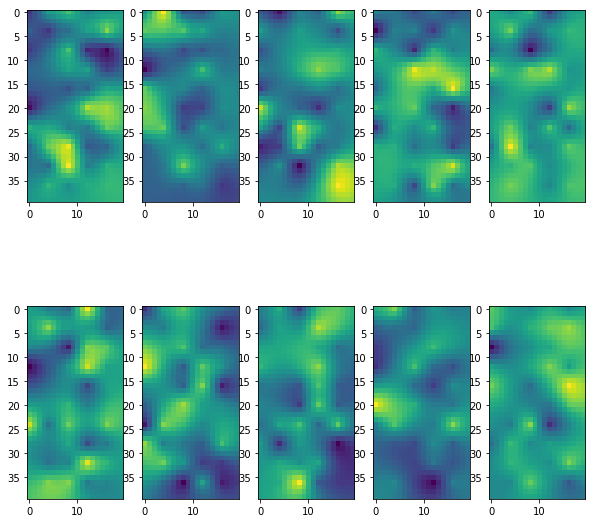

In [11]:
plot_first_10_reals(mc.parensemble)

Do these look "right" (from a geologic stand point)?

Let's use a full covariance matrix and see how that looks

,rch_0,rch_1,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
rch_0,0.003076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rch_1,0.000000,0.003076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk00,0.000000,0.000000,0.250000,0.226209,0.204683,0.185205,0.167580,0.226209,0.217031,0.199907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk01,0.000000,0.000000,0.226209,0.250000,0.226209,0.204683,0.185205,0.217031,0.226209,0.217031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk02,0.000000,0.000000,0.204683,0.226209,0.250000,0.226209,0.204683,0.199907,0.217031,0.226209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


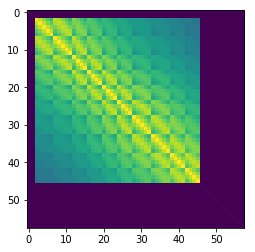

In [12]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=10000)
gs = pyemu.utils.geostats.GeoStruct(variograms=[v])
#gs.variograms[0].a=10000
#gs.variograms[0].contribution=0.01
#gs.variograms[0].anisotropy = 10.0
# pp_df = pyemu.utils.gw_utils.pp_file_to_dataframe("points1.dat")
# parcov_hk = gs.covariance_matrix(pp_df.x,pp_df.y,pp_df.name)
# parcov_full = parcov_hk.extend(parcov_rch)
pp_tpl = os.path.join(working_dir,"hkpp.dat.tpl")
cov = pyemu.helpers.pilotpoint_prior_builder(pst=mc.pst,struct_dict={gs:pp_tpl})
plt.imshow(cov.x,interpolation="nearest")
cov.to_dataframe().head()

In [13]:
mc_full = pyemu.MonteCarlo(pst=pst,parcov=cov)

In [14]:
mc_full.draw(100)

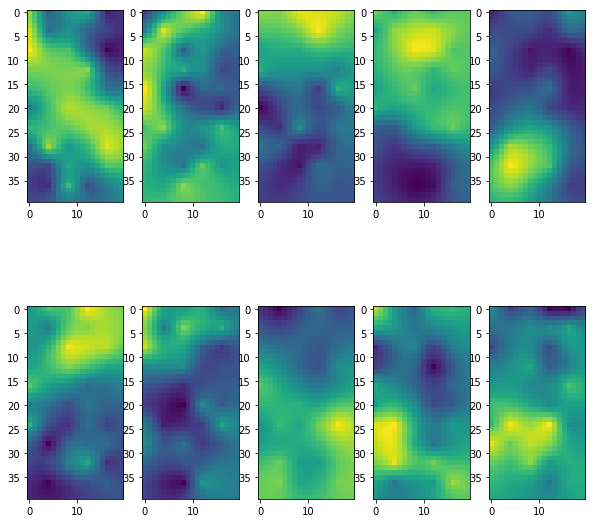

In [15]:
plot_first_10_reals(mc_full.parensemble)

In [16]:
mc_full.draw(100)

In [17]:
mc_full.parensemble.to_csv(os.path.join(working_dir,"sweep_in.csv"))

In [18]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_file,num_slaves=10,
                           master_dir='.')
os.chdir("..")

In [24]:
df_out = pd.read_csv(os.path.join(working_dir,"sweep_out.csv"),index_col=0)
df_out.columns = [c.lower() for c in df_out.columns]

In [25]:

df_out = df_out.loc[df_out.failed_flag==0,:] #drop an failed runs
df_out.head()

,input_run_id,failed_flag,phi,meas_phi,regul_phi,vol_percent,calflux,flx_total,flx_recharg,vol_total,...,vol_total_19750101,vol_wells_19750101,vol_constan_19750102,vol_in-out_19750102,vol_percent_19750102,vol_recharg_19750102,vol_river_l_19750102,vol_storage_19750102,vol_total_19750102,vol_wells_19750102
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1962.126516,1961.948389,0.178127,0,409.089543,0,0,0,...,525.0,-4000485.25,-325.890625,525.0,0.00,9140631.0,-5156269.00,19164.925781,525.0,-4002676.25
1,1,0,10704.620179,10704.389171,0.231009,0,6817.705687,0,0,0,...,33.0,-4074120.50,-249666.437500,33.0,0.00,7522275.0,-3270153.75,73930.554688,33.0,-4076351.75
2,2,0,5033.070164,5032.967776,0.102388,0,1791.437848,0,0,0,...,33.0,-4229510.50,-235792.343750,32.0,0.00,7075163.5,-2705933.25,98421.343750,32.0,-4231827.00
3,3,0,7911.830700,7911.644365,0.186335,0,1121.006513,0,0,0,...,42.0,-4146678.50,-291889.750000,42.0,0.00,7632247.5,-3319012.25,127645.304688,42.0,-4148949.50
4,4,0,2151.012096,2150.744090,0.268006,0,0.439858,0,0,0,...,1536.0,-4998745.00,-41252.078125,1536.0,0.01,5842407.5,-841786.50,43649.445312,1536.0,-5001483.00


In [26]:
acceptable_phi = 5000.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

[ 0  4  5  7  9 11 12 16 18 19 20 24 26 28 29 30 34 35 36 40 43 45 46 50 54
 56 66 68 75 83 85]


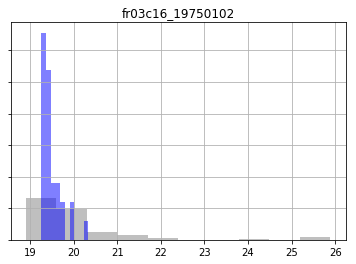

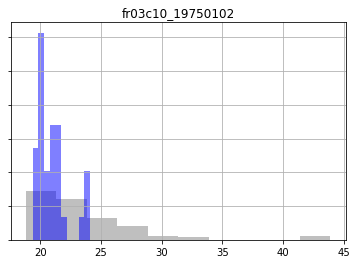

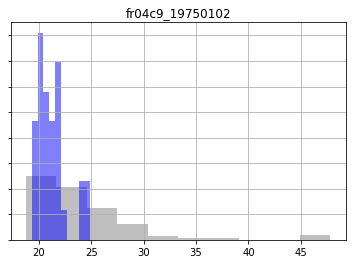

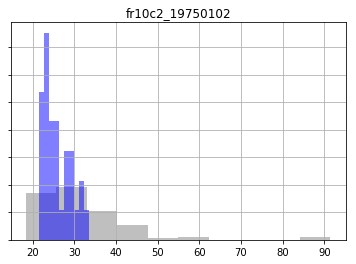

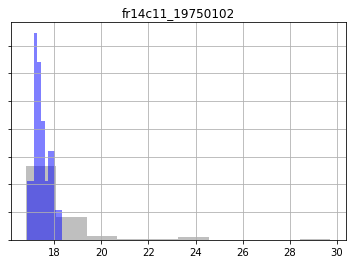

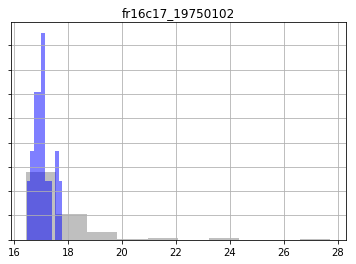

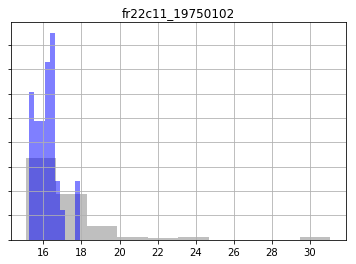

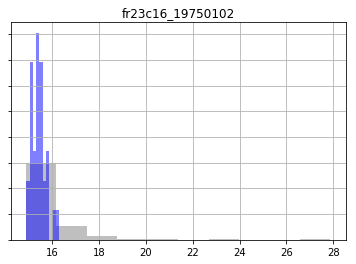

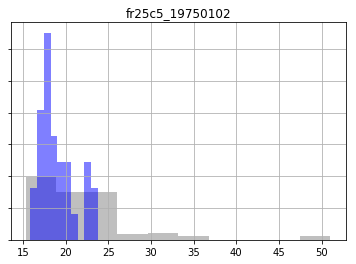

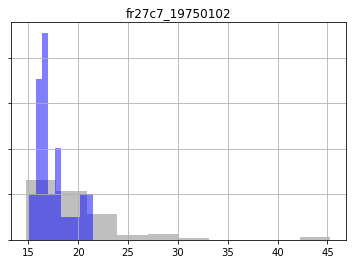

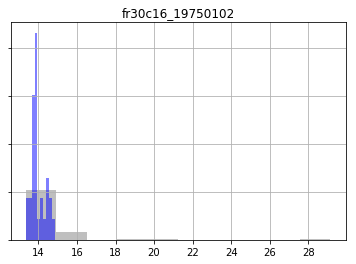

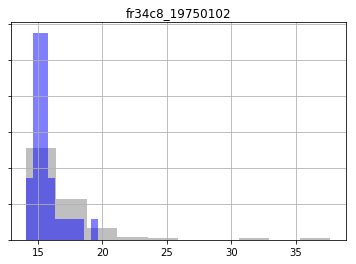

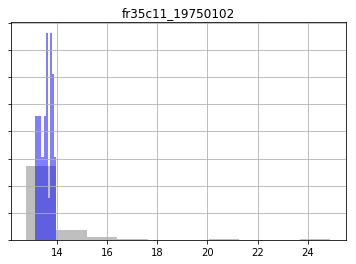

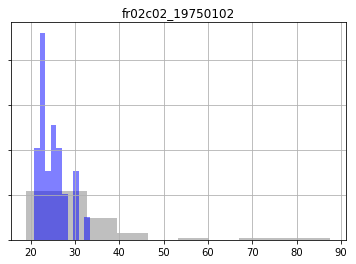

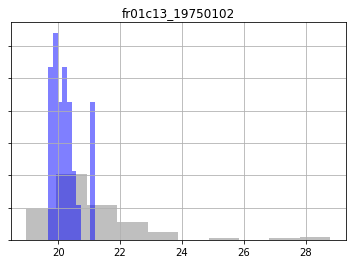

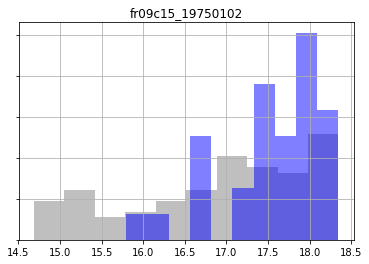

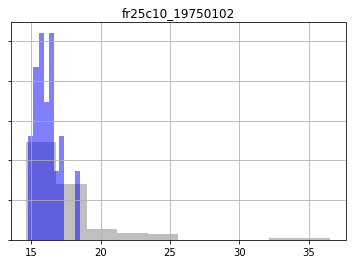

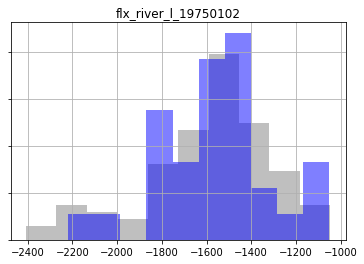

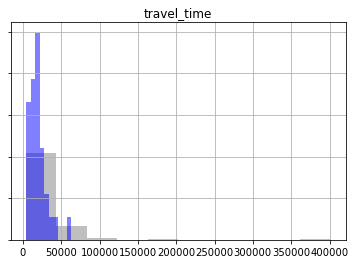

In [28]:
for forecast in mc.pst.forecast_names:
    ax = df_out.loc[:,forecast].hist(alpha=0.5,color='0.5',normed=True)
    ax.set_yticklabels([])
    df_out.loc[good_enough,forecast].hist(ax=ax,alpha=0.5,color='b',normed=True)
    ax.set_title(forecast)
    plt.show()